In [76]:
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
# Descargamos un dataset de huggingface.com usando la librería datasets
dataset = load_dataset("sentiment140")
# Seleccionamos un conjunto de test de ese dataset.
test_dataset = dataset["test"].to_iterable_dataset()

In [77]:
df = pd.json_normalize(test_dataset)
df.loc[df['sentiment'] < 2, 'original'] = 'Negative'
df.loc[df['sentiment'] > 1, 'original'] = 'Positive'
df['promtpsentiment'] = None
df['vader'] = None
df.head()

,text,date,user,sentiment,query,original,promtpsentiment,vander
0,@stellargirl I loooooooovvvvvveee my Kindle2. ...,Mon May 11 03:17:40 UTC 2009,tpryan,4,kindle2,Positive,None,None
1,Reading my kindle2... Love it... Lee childs i...,Mon May 11 03:18:03 UTC 2009,vcu451,4,kindle2,Positive,None,None
2,"Ok, first assesment of the #kindle2 ...it fuck...",Mon May 11 03:18:54 UTC 2009,chadfu,4,kindle2,Positive,None,None
3,@kenburbary You'll love your Kindle2. I've had...,Mon May 11 03:19:04 UTC 2009,SIX15,4,kindle2,Positive,None,None
4,@mikefish Fair enough. But i have the Kindle2...,Mon May 11 03:21:41 UTC 2009,yamarama,4,kindle2,Positive,None,None


In [79]:
import openai
import os
import json

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

openai.api_key  = os.getenv('OPENAI_API_KEY')

def parse_response(response):
        if type(response) == dict:
            if response.keys().__contains__("generated_text"):
                return parse_response(response["generated_text"])
            if response.keys().__contains__("choices"):
                return parse_response(response["choices"][0])
            elif response.keys().__contains__("text"):
                return parse_response(response["text"])
            else:
                return response
        if type(response) == list:
             return parse_response(response[0])
        if type(response) == str:
            return json.loads(response)


def get_completion(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0, # this is the degree of randomness of the model's output
    )
    return response.choices[0].message["content"]

for i in range(df.shape[0]):
    reviewText = df.at[i, 'text']
    prompt =f'Return a json with the following information extracted from the review below you can find the review between triple backticks: \
        {{ \
            "Sentiment": "(Positive or Negative)",\
            "Stars": "Number of stars depending on the sentiment of the Review",\
            "Anger": "Is the user angry (True or False)", \
        }} \
    Review: ```' + \
    reviewText + \
    '``` \
    If the information is not present, use ""unknown"" as the value. \
    Remember to return only the json. \
    '	
    output = get_completion(prompt)
    try:
        response = parse_response(output)
        df.at[i,"promtpsentiment"] = response["Sentiment"]
    except:
        print("Error procesando reseña: ", output)
        

In [92]:
#pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer=SentimentIntensityAnalyzer()
def get_vader_score(sentence): 
    compound=analyzer.polarity_scores(sentence)['compound']
    if compound > 0.05: 
        return "Positive"
    else: 
        return "Negative"
    
df['vader']=df.apply(lambda x: get_vader_score(x['text']), axis=1)

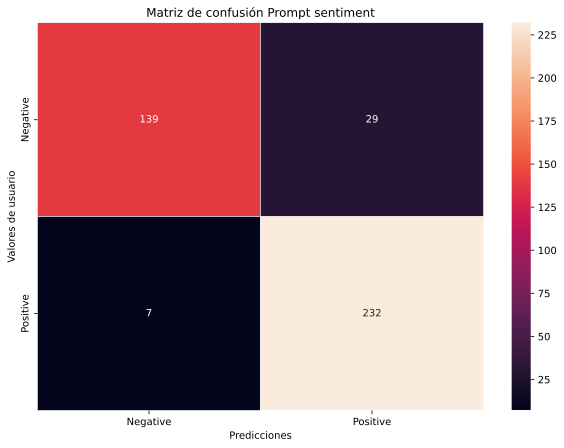

In [95]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'
from sklearn.metrics import confusion_matrix
import seaborn as sn
df_drop = df.replace('', np.nan)
df_drop = df_drop.replace('unknown', np.nan)
df_drop = df_drop.replace('Unknown', np.nan)
df_drop = df_drop.dropna(subset=['promtpsentiment','original','vader'])
df_drop = df_drop.astype({'promtpsentiment': 'str', 'original': 'str', 'vader':'str'})

array = confusion_matrix(y_true=df_drop['original'], y_pred=df_drop['promtpsentiment'], labels = ['Negative','Positive'])

df_cm = pd.DataFrame(array, index = [i for i in ['Negative','Positive']],
                  columns = [i for i in ['Negative','Positive']])

plt.figure(figsize = (10,7))
ax = plt.axes()
sn.heatmap(df_cm, annot=True, fmt="d", linewidths=.5, ax=ax)
ax.set_title(f'Matriz de confusión Prompt sentiment')
ax.set_xlabel('Predicciones')
ax.set_ylabel('Valores de usuario')
plt.show()

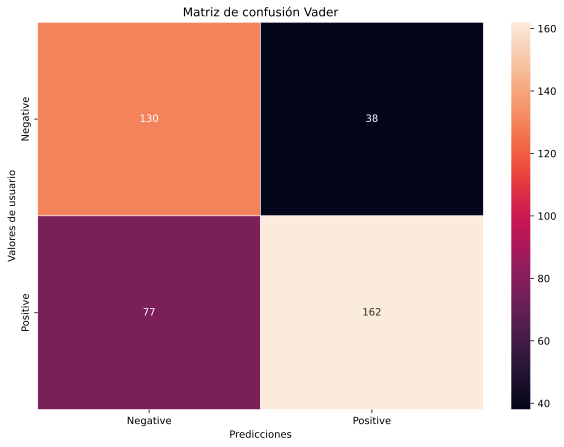

In [96]:
array = confusion_matrix(y_true=df_drop['original'], y_pred=df_drop['vader'], labels = ['Negative','Positive'])

df_cm = pd.DataFrame(array, index = [i for i in ['Negative','Positive']],
                  columns = [i for i in ['Negative','Positive']])

plt.figure(figsize = (10,7))
ax = plt.axes()
sn.heatmap(df_cm, annot=True, fmt="d", linewidths=.5, ax=ax)
ax.set_title(f'Matriz de confusión Vader')
ax.set_xlabel('Predicciones')
ax.set_ylabel('Valores de usuario')
plt.show()

In [97]:
from sklearn.metrics import precision_score, recall_score
precision = precision_score(df_drop['original'], df_drop['promtpsentiment'], labels = ['Negative','Positive'], pos_label='Positive')
recall = recall_score(df_drop['original'], df_drop['promtpsentiment'], labels = ['Negative','Positive'], pos_label='Positive')
print("Resultados con Prompt sentiment: ")
print ("Precisión: ", precision)
print ("Exhaustividad: ", recall)

Resultados con Prompt sentiment: 
Precisión:  0.8888888888888888
Exhaustividad:  0.9707112970711297


In [98]:
precision = precision_score(df_drop['original'], df_drop['vader'], labels = ['Negative','Positive'], pos_label='Positive')
recall = recall_score(df_drop['original'], df_drop['vader'], labels = ['Negative','Positive'], pos_label='Positive')
print("Resultados con vader: ")
print ("Precisión: ", precision)
print ("Exhaustividad: ", recall)

Resultados con vader: 
Precisión:  0.81
Exhaustividad:  0.6778242677824268
